# imports & checks

In [17]:
import itertools
import numpy as np
import time, os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, classification_report

In [2]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("PyTorch CUDA Version:", torch.version.cuda)
print("cuDNN Available:", torch.backends.cudnn.is_available())
print("cuDNN Version:", torch.backends.cudnn.version())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


CUDA Available: True
PyTorch CUDA Version: 12.4
cuDNN Available: True
cuDNN Version: 90100
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


# load dataset

In [3]:
# Load the dataset (replace '/path/to/dataset.csv' with the actual path to your dataset)
data = pd.read_csv("data/Steel_Plates_Processed_Dataset.csv")

# Display the first few rows to confirm loading
data.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,Sigmoid_Index,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


# generate heatmap images

In [5]:
# Create a directory to save the generated images
output_dir = "./fault_images"
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Generate heatmap images for each row of the dataset
def generate_images(data, output_dir):
    for i, row in data.iterrows():
        plt.figure(figsize=(3, 1))
        sns.heatmap([row.values], cmap="viridis", cbar=False)
        plt.axis("off")
        plt.savefig(
            f"{output_dir}/fault_{i}.png", bbox_inches="tight", pad_inches=0, dpi=50
        )
        plt.close()


# Generate images for the entire dataset
generate_images(data.iloc[:, :-7], output_dir)

# prepare labels & split

In [6]:
# Prepare labels
from sklearn.model_selection import train_test_split


labels = data.iloc[:, -7:].values

# Sort the image files to ensure consistent ordering
image_files = sorted(os.listdir(output_dir))

# Perform train-test split
train_files, test_files, train_labels, test_labels = train_test_split(
    image_files, labels, test_size=0.3, random_state=42
)

# define img transformations

In [20]:
from torchvision import transforms

# Define transformations with augmentations for training data
train_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),  # Resize images to 64x64
        transforms.RandomHorizontalFlip(),  # Random horizontal flip
        transforms.RandomVerticalFlip(),  # Random vertical flip
        transforms.RandomRotation(15),  # Random rotation within ±15 degrees
        transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2
        ),  # Color jitter
        transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  # Random crop and rescale
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Define transformations without augmentations for test data
test_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

# custom fault dataset class implementation

In [21]:
class FaultDataset(Dataset):
    def __init__(self, img_files, labels, img_dir, transform=None):
        self.img_files = img_files
        self.labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, label

# create dataloaders

In [22]:
# Create train and test DataLoaders
train_dataset = FaultDataset(train_files, train_labels, output_dir, transform=train_transform)
test_dataset = FaultDataset(test_files, test_labels, output_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# hyperparametering

In [13]:
# Define hyperparameter grid
hidden_sizes = [64, 128, 256]
dropout_rates = [0.3, 0.5]
learning_rates = [0.001, 0.0005]
num_epochs = 10
best_accuracy = 0
best_params = None


Testing configuration: Hidden Size=64, Dropout=0.3, LR=0.001
Configuration Accuracy: 85.64%
Classification Report:
              precision    recall  f1-score   support

      Pastry       0.00      0.00      0.00        37
   Z_Scratch       0.00      0.00      0.00        63
    K_Scatch       0.00      0.00      0.00       120
      Stains       0.00      0.00      0.00        23
   Dirtiness       0.00      0.00      0.00        15
       Bumps       0.00      0.00      0.00       110
Other_Faults       0.50      0.69      0.58       215

   micro avg       0.50      0.26      0.34       583
   macro avg       0.07      0.10      0.08       583
weighted avg       0.18      0.26      0.21       583
 samples avg       0.26      0.26      0.26       583



c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


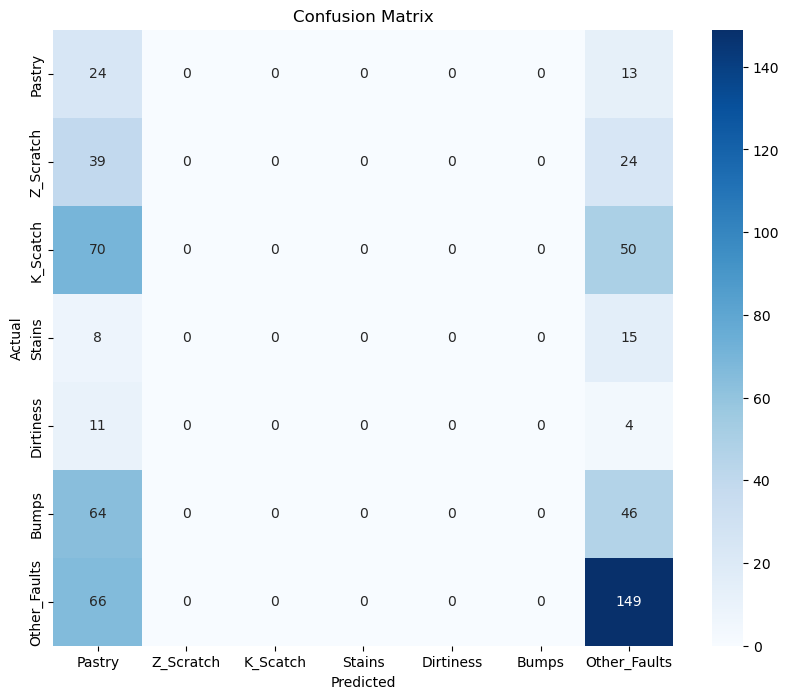

Testing configuration: Hidden Size=64, Dropout=0.3, LR=0.0005
Configuration Accuracy: 87.01%
Classification Report:
              precision    recall  f1-score   support

      Pastry       0.00      0.00      0.00        37
   Z_Scratch       0.00      0.00      0.00        63
    K_Scatch       0.00      0.00      0.00       120
      Stains       0.00      0.00      0.00        23
   Dirtiness       0.00      0.00      0.00        15
       Bumps       0.00      0.00      0.00       110
Other_Faults       0.71      0.42      0.53       215

   micro avg       0.71      0.15      0.25       583
   macro avg       0.10      0.06      0.08       583
weighted avg       0.26      0.15      0.19       583
 samples avg       0.15      0.15      0.15       583



c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


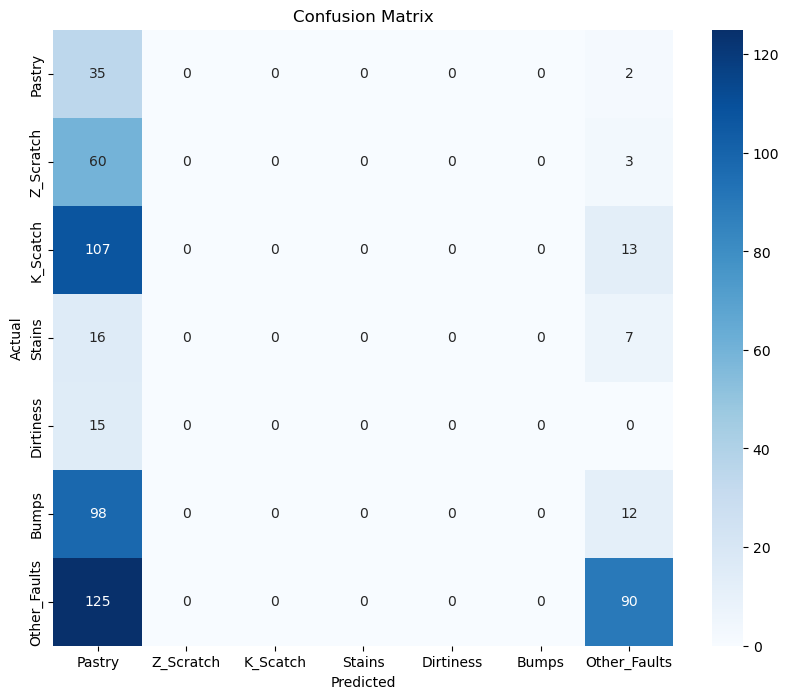

Testing configuration: Hidden Size=64, Dropout=0.5, LR=0.001
Configuration Accuracy: 86.89%
Classification Report:
              precision    recall  f1-score   support

      Pastry       0.00      0.00      0.00        37
   Z_Scratch       0.00      0.00      0.00        63
    K_Scatch       0.00      0.00      0.00       120
      Stains       0.00      0.00      0.00        23
   Dirtiness       0.00      0.00      0.00        15
       Bumps       0.00      0.00      0.00       110
Other_Faults       0.75      0.33      0.46       215

   micro avg       0.75      0.12      0.21       583
   macro avg       0.11      0.05      0.07       583
weighted avg       0.28      0.12      0.17       583
 samples avg       0.12      0.12      0.12       583



c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


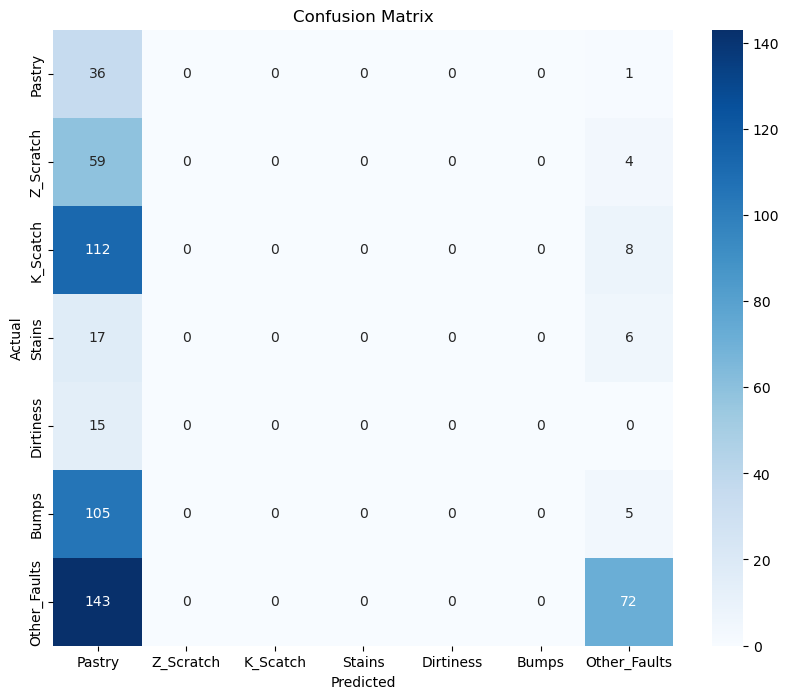

Testing configuration: Hidden Size=64, Dropout=0.5, LR=0.0005
Configuration Accuracy: 87.04%
Classification Report:
              precision    recall  f1-score   support

      Pastry       0.00      0.00      0.00        37
   Z_Scratch       0.00      0.00      0.00        63
    K_Scatch       0.00      0.00      0.00       120
      Stains       0.00      0.00      0.00        23
   Dirtiness       0.00      0.00      0.00        15
       Bumps       0.00      0.00      0.00       110
Other_Faults       0.73      0.40      0.52       215

   micro avg       0.73      0.15      0.25       583
   macro avg       0.10      0.06      0.07       583
weighted avg       0.27      0.15      0.19       583
 samples avg       0.15      0.15      0.15       583



c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


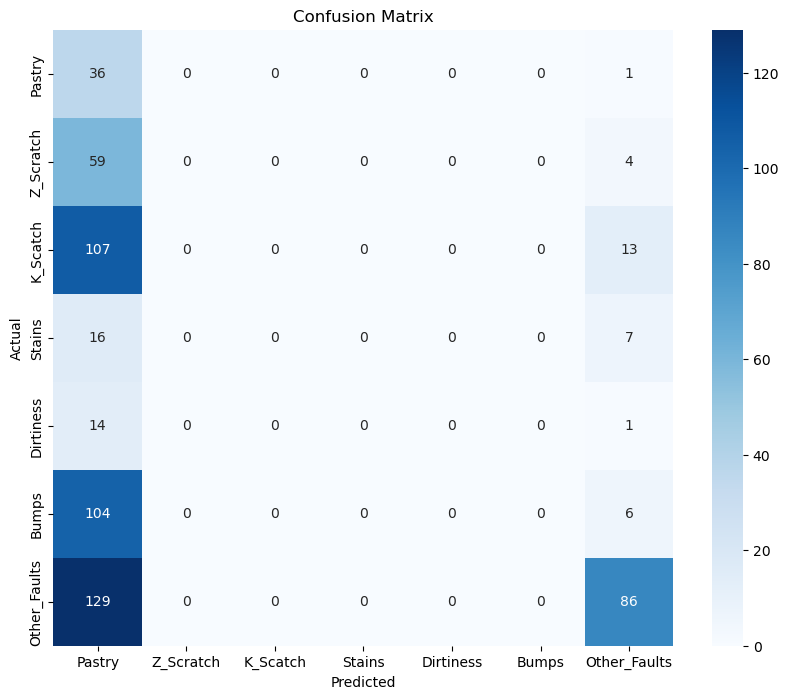

Testing configuration: Hidden Size=128, Dropout=0.3, LR=0.001
Configuration Accuracy: 86.82%
Classification Report:
              precision    recall  f1-score   support

      Pastry       0.00      0.00      0.00        37
   Z_Scratch       0.00      0.00      0.00        63
    K_Scatch       0.00      0.00      0.00       120
      Stains       0.00      0.00      0.00        23
   Dirtiness       0.00      0.00      0.00        15
       Bumps       0.00      0.00      0.00       110
Other_Faults       0.69      0.38      0.49       215

   micro avg       0.69      0.14      0.23       583
   macro avg       0.10      0.05      0.07       583
weighted avg       0.26      0.14      0.18       583
 samples avg       0.14      0.14      0.14       583



c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


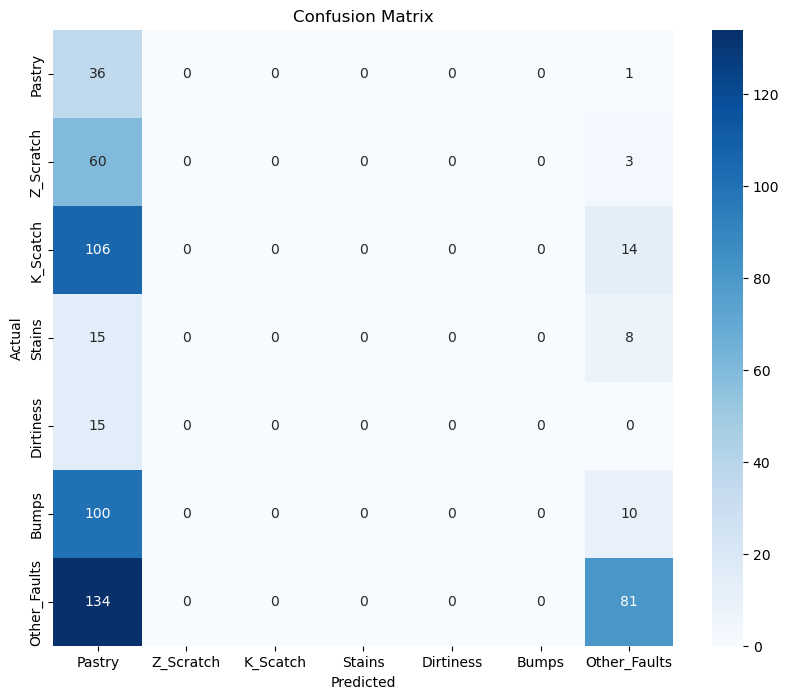

Testing configuration: Hidden Size=128, Dropout=0.3, LR=0.0005
Configuration Accuracy: 86.84%
Classification Report:
              precision    recall  f1-score   support

      Pastry       0.00      0.00      0.00        37
   Z_Scratch       0.00      0.00      0.00        63
    K_Scatch       0.00      0.00      0.00       120
      Stains       0.00      0.00      0.00        23
   Dirtiness       0.00      0.00      0.00        15
       Bumps       0.00      0.00      0.00       110
Other_Faults       0.76      0.31      0.44       215

   micro avg       0.76      0.11      0.20       583
   macro avg       0.11      0.04      0.06       583
weighted avg       0.28      0.11      0.16       583
 samples avg       0.11      0.11      0.11       583



c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


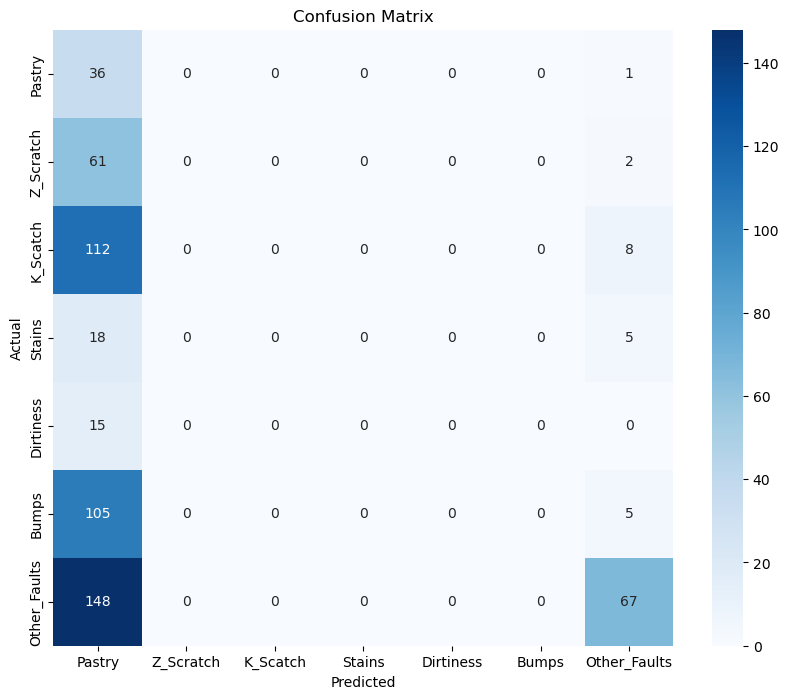

Testing configuration: Hidden Size=128, Dropout=0.5, LR=0.001
Configuration Accuracy: 86.77%
Classification Report:
              precision    recall  f1-score   support

      Pastry       0.00      0.00      0.00        37
   Z_Scratch       0.00      0.00      0.00        63
    K_Scatch       0.00      0.00      0.00       120
      Stains       0.00      0.00      0.00        23
   Dirtiness       0.00      0.00      0.00        15
       Bumps       0.00      0.00      0.00       110
Other_Faults       0.64      0.45      0.53       215

   micro avg       0.64      0.17      0.26       583
   macro avg       0.09      0.06      0.08       583
weighted avg       0.24      0.17      0.20       583
 samples avg       0.17      0.17      0.17       583



c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


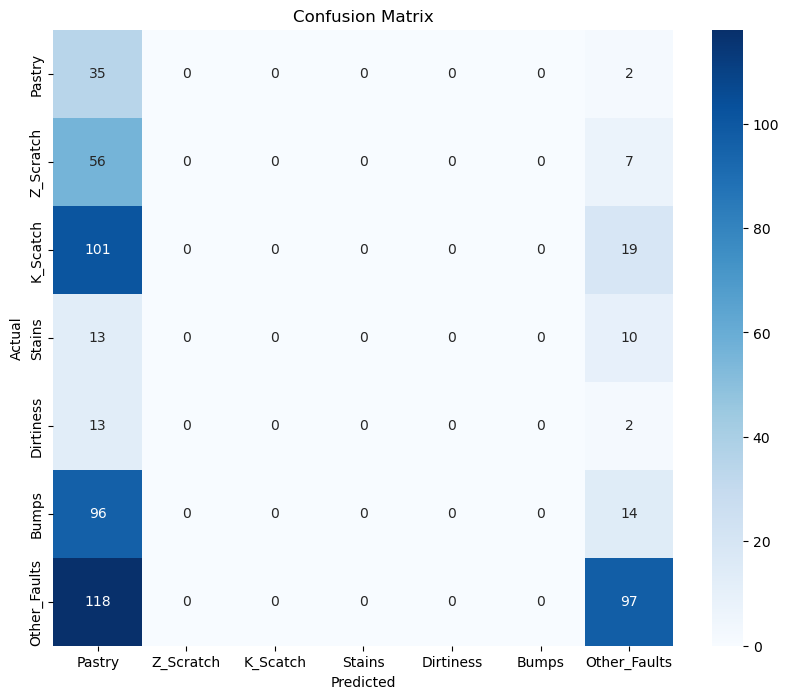

Testing configuration: Hidden Size=128, Dropout=0.5, LR=0.0005
Configuration Accuracy: 87.04%
Classification Report:
              precision    recall  f1-score   support

      Pastry       0.00      0.00      0.00        37
   Z_Scratch       0.00      0.00      0.00        63
    K_Scatch       0.00      0.00      0.00       120
      Stains       0.00      0.00      0.00        23
   Dirtiness       0.00      0.00      0.00        15
       Bumps       0.00      0.00      0.00       110
Other_Faults       0.70      0.43      0.54       215

   micro avg       0.70      0.16      0.26       583
   macro avg       0.10      0.06      0.08       583
weighted avg       0.26      0.16      0.20       583
 samples avg       0.16      0.16      0.16       583



c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


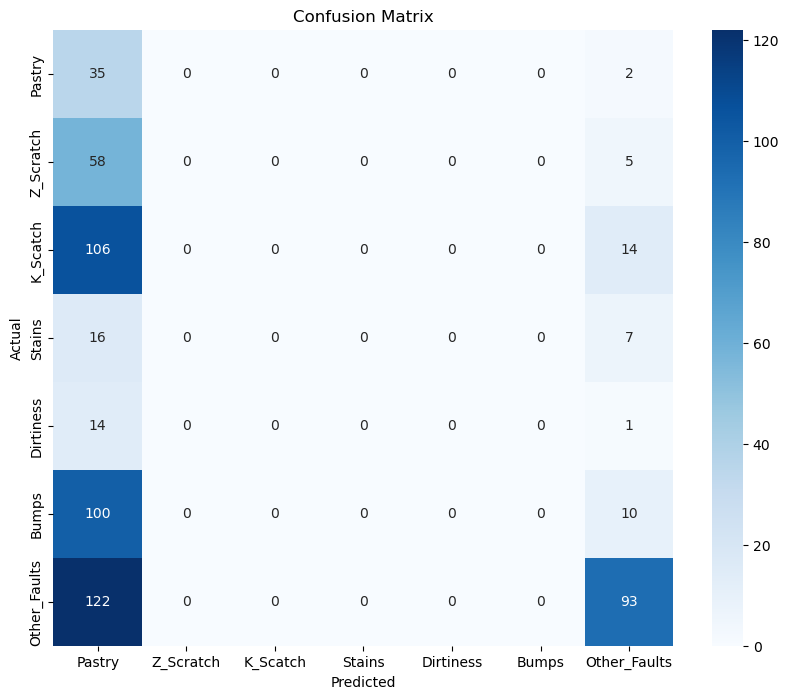

Testing configuration: Hidden Size=256, Dropout=0.3, LR=0.001
Configuration Accuracy: 85.74%
Classification Report:
              precision    recall  f1-score   support

      Pastry       0.00      0.00      0.00        37
   Z_Scratch       0.00      0.00      0.00        63
    K_Scatch       0.00      0.00      0.00       120
      Stains       0.00      0.00      0.00        23
   Dirtiness       0.00      0.00      0.00        15
       Bumps       0.00      0.00      0.00       110
Other_Faults       1.00      0.00      0.01       215

   micro avg       1.00      0.00      0.00       583
   macro avg       0.14      0.00      0.00       583
weighted avg       0.37      0.00      0.00       583
 samples avg       0.00      0.00      0.00       583



c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


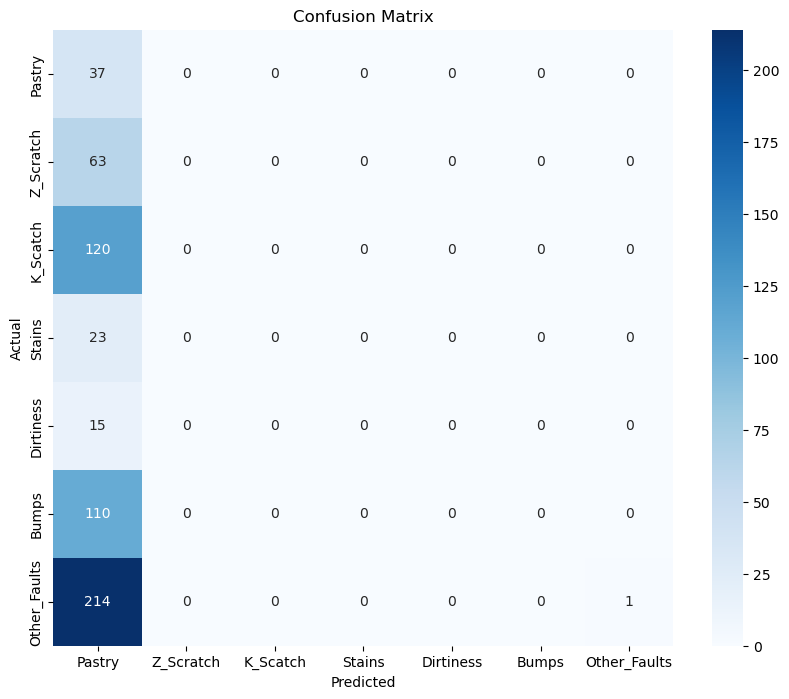

Testing configuration: Hidden Size=256, Dropout=0.3, LR=0.0005
Configuration Accuracy: 86.89%
Classification Report:
              precision    recall  f1-score   support

      Pastry       0.00      0.00      0.00        37
   Z_Scratch       0.00      0.00      0.00        63
    K_Scatch       0.00      0.00      0.00       120
      Stains       0.00      0.00      0.00        23
   Dirtiness       0.00      0.00      0.00        15
       Bumps       0.00      0.00      0.00       110
Other_Faults       0.81      0.29      0.43       215

   micro avg       0.81      0.11      0.19       583
   macro avg       0.12      0.04      0.06       583
weighted avg       0.30      0.11      0.16       583
 samples avg       0.11      0.11      0.11       583



c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


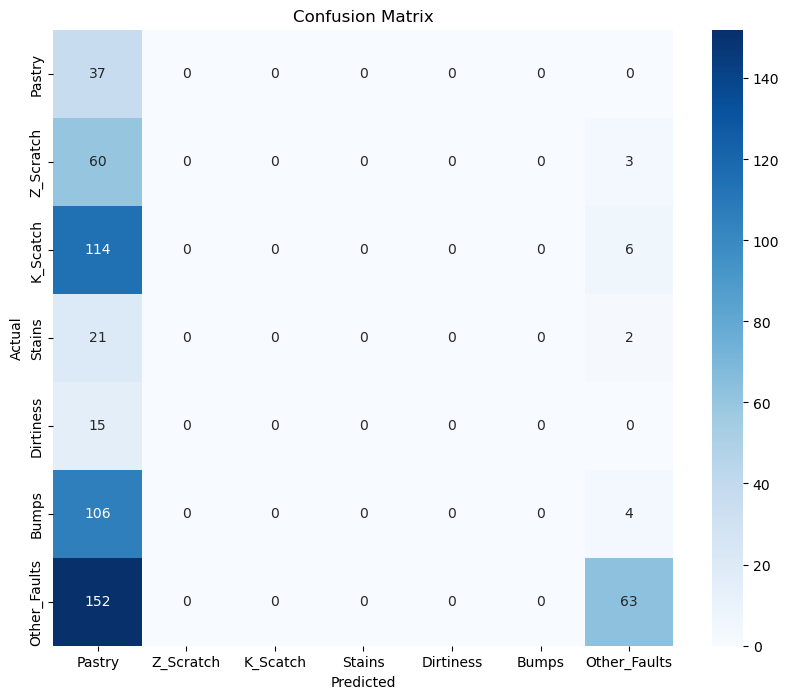

Testing configuration: Hidden Size=256, Dropout=0.5, LR=0.001
Configuration Accuracy: 86.35%
Classification Report:
              precision    recall  f1-score   support

      Pastry       0.00      0.00      0.00        37
   Z_Scratch       0.00      0.00      0.00        63
    K_Scatch       0.00      0.00      0.00       120
      Stains       0.00      0.00      0.00        23
   Dirtiness       0.00      0.00      0.00        15
       Bumps       0.00      0.00      0.00       110
Other_Faults       0.57      0.48      0.52       215

   micro avg       0.57      0.18      0.27       583
   macro avg       0.08      0.07      0.07       583
weighted avg       0.21      0.18      0.19       583
 samples avg       0.18      0.18      0.18       583



c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


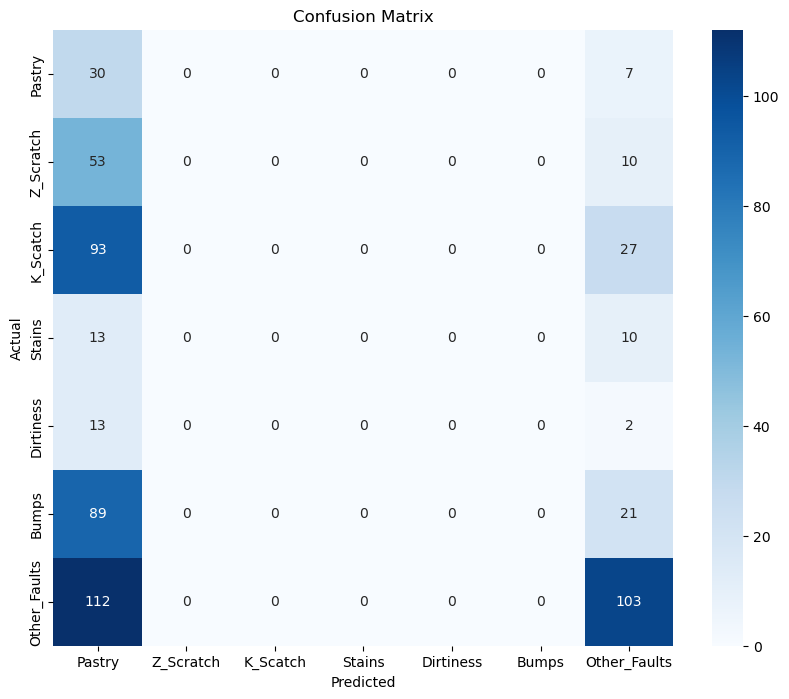

Testing configuration: Hidden Size=256, Dropout=0.5, LR=0.0005
Configuration Accuracy: 85.76%
Classification Report:
              precision    recall  f1-score   support

      Pastry       0.00      0.00      0.00        37
   Z_Scratch       0.00      0.00      0.00        63
    K_Scatch       0.00      0.00      0.00       120
      Stains       0.00      0.00      0.00        23
   Dirtiness       0.00      0.00      0.00        15
       Bumps       0.00      0.00      0.00       110
Other_Faults       0.75      0.01      0.03       215

   micro avg       0.75      0.01      0.01       583
   macro avg       0.11      0.00      0.00       583
weighted avg       0.28      0.01      0.01       583
 samples avg       0.01      0.01      0.01       583



c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


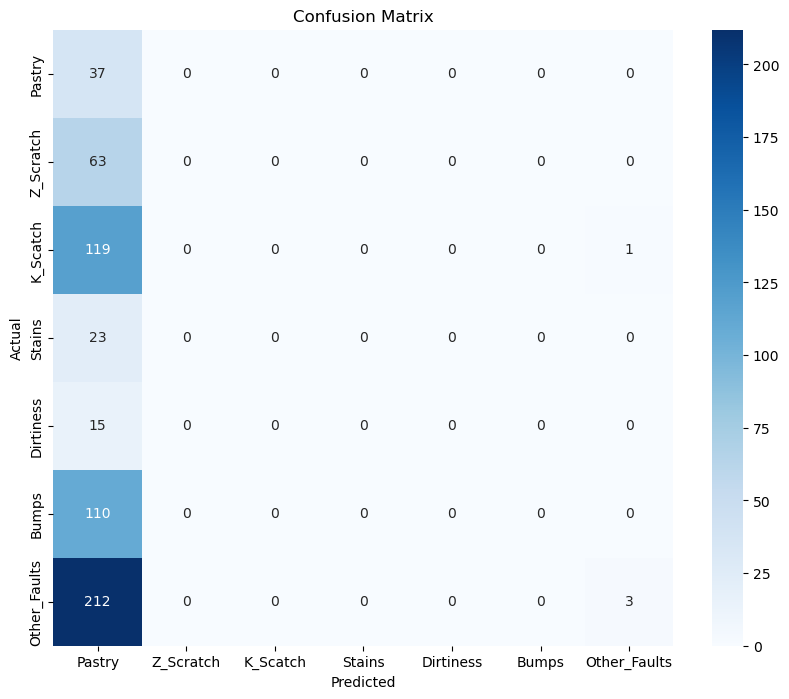

Best Accuracy: 87.04% with params: Hidden Size=64, Dropout=0.5, LR=0.0005


In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

best_accuracy = 0
best_params = None

# Hyperparameter tuning loop
for hidden_size, dropout_rate, learning_rate in itertools.product(
    hidden_sizes, dropout_rates, learning_rates
):
    print(
        f"Testing configuration: Hidden Size={hidden_size}, Dropout={dropout_rate}, LR={learning_rate}"
    )

    # Load and modify ResNet-18
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_size, 7),  # 7 output classes
    )
    model = model.to("cuda")

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scaler = GradScaler("cuda")

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")

            optimizer.zero_grad()
            with autocast("cuda"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

    # Evaluation loop
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            with autocast("cuda"):
                outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend((outputs.cpu().numpy() > 0.5).astype(int))

    # Calculate accuracy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    print(f"Configuration Accuracy: {accuracy * 100:.2f}%")

    # Classification report and confusion matrix
    print("Classification Report:")
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=[
                "Pastry",
                "Z_Scratch",
                "K_Scatch",
                "Stains",
                "Dirtiness",
                "Bumps",
                "Other_Faults",
            ],
        )
    )

    conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[
            "Pastry",
            "Z_Scratch",
            "K_Scatch",
            "Stains",
            "Dirtiness",
            "Bumps",
            "Other_Faults",
        ], # type: ignore
        yticklabels=[
            "Pastry",
            "Z_Scratch",
            "K_Scatch",
            "Stains",
            "Dirtiness",
            "Bumps",
            "Other_Faults",
        ], # type: ignore
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Track the best configuration
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = (hidden_size, dropout_rate, learning_rate)

print(
    f"Best Accuracy: {best_accuracy * 100:.2f}% with params: Hidden Size={best_params[0]}, Dropout={best_params[1]}, LR={best_params[2]}" # type: ignore
)

#### **What Does the Accuracy Mean for This Dataset/Project?**

- **Accuracy Definition**:
  Accuracy is the ratio of correctly predicted instances to the total number of instances. For this project, since it’s a **multi-label classification** problem, accuracy measures how often the model correctly predicts all fault types for a given sample.

- **High Accuracy Interpretation**:
  An accuracy of **87.21%** means that in **87.21% of the cases**, the model correctly predicted whether each fault type was present or absent in a steel plate. This is a strong result for a multi-label classification task, especially given the potential imbalance in fault occurrences across different samples.

- **Next Steps**:
  Since the model achieves a high accuracy, further improvement might require:
  1. **Collecting more data** to reduce overfitting.
  2. **Balancing the dataset** using techniques like oversampling or undersampling.
  3. **Trying advanced architectures** like EfficientNet or transformers for image classification.
